In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pickle

In [2]:
# Function to create and display the confusion matrix
def plot_confusion_matrix(cm, classes, title, dataset_name):
    plt.figure(figsize=(8, 8))
    percentages = (cm.T / cm.sum(axis=1) * 100).T
    plt.imshow(percentages, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=100)
    plt.title(f'Confusion Matrix - {title} - {dataset_name}')
    plt.colorbar(label='Percentage')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm[i, j]}\n{percentages[i, j]:.1f}%", horizontalalignment='center',
                     color='white' if percentages[i, j] > 50 else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.close()

def calculate_class_accuracies(cm):
    """
    Calculate the accuracy for each class based on the confusion matrix.

    Parameters:
    - cm (numpy.ndarray): Confusion matrix where cm[i, j] represents the number of times 
                          class i was predicted as class j.

    Returns:
    - class_accuracies (dict): A dictionary where the keys are class indices and the values 
                               are the accuracies for each class.
    """
    class_accuracies = {}
    total_instances_per_class = cm.sum(axis=1)  # Sum of instances for each true class
    for i in range(len(cm)):
        if total_instances_per_class[i] > 0:
            # Calculate accuracy as the number of correct predictions divided by the total instances of the class
            class_accuracies[i] = cm[i, i] / total_instances_per_class[i]
        else:
            # Handle cases where there are no instances of the class
            class_accuracies[i] = None
    
    return class_accuracies

def calculate_custom_accuracies(cm):
    """
    Calculate the custom accuracy for each class based on a specific condition where predictions
    are considered correct if they fall within a defined range around the true class.

    Parameters:
    - cm (numpy.ndarray): Confusion matrix where cm[i, j] represents the number of times 
                          class i was predicted as class j.

    Returns:
    - class_accuracies (dict): A dictionary where the keys are class indices and the values 
                               are the custom accuracies for each class.
    """
    # Define allowable predictions for each true class (adjusted for 1-based indexing)
    allowed_predictions = {
        1: [5, 1, 2],  # True 1 corresponds to index 1
        2: [1, 2, 3],  # True 2 corresponds to index 2
        3: [2, 3, 4],  # True 3 corresponds to index 3
        4: [3, 4, 5],  # True 4 corresponds to index 4
        5: [4, 5, 1],   # True 5 corresponds to index 5
        6: [6],
        7: [7],
    }

    class_accuracies = {}
    total_instances_per_class = cm.sum(axis=1)  # Sum of instances for each true class

    for true_class in range(len(cm)):
        correct_predictions = 0
        if total_instances_per_class[true_class] > 0:
            true_class_index = true_class + 1  # Adjust for 1-based indexing
            for pred_class in range(len(cm)):
                pred_class_index = pred_class + 1  # Adjust for 1-based indexing
                if pred_class_index in allowed_predictions.get(true_class_index, []):
                    correct_predictions += cm[true_class, pred_class]
            class_accuracies[true_class_index] = correct_predictions / total_instances_per_class[true_class]
        else:
            class_accuracies[true_class_index] = None
    
    return class_accuracies

In [3]:
# Import Data
with open('/data/ksa/04_Data_Preprocessing/training-test/32/training_imputation_32_VH_unrecode.pkl', 'rb') as f:
    data = pickle.load(f)
data.head()

,idpoint,idsubsegment,idsegment,nth,periode,observation,MGRS,VH_30,VH_29,VH_28,...,VH_7,VH_6,VH_5,VH_4,VH_3,VH_2,VH_1,VH_0,year,date
0,320201009A1#01,320201009A1,320201009,1,2022_03,8.0,48MXS,-13.950575,-13.704084,-13.918890,...,-13.482984,-12.038650,-12.308728,-12.026812,-12.877756,-14.129539,-13.121758,-13.279804,2022,2022-01-01
1,320201009A1#02,320201009A1,320201009,1,2022_03,8.0,48MXS,-12.331718,-11.972934,-12.526777,...,-12.722636,-12.356975,-11.897697,-11.334288,-12.226791,-13.437385,-12.356170,-13.047971,2022,2022-01-01
2,320201009A1#03,320201009A1,320201009,1,2022_03,8.0,48MXS,-11.529987,-11.416285,-12.503205,...,-13.417534,-13.683514,-13.061878,-12.575087,-12.567230,-12.675266,-12.290981,-13.212626,2022,2022-01-01
3,320201009A1#04,320201009A1,320201009,1,2022_03,8.0,48MXS,-13.361443,-13.600700,-14.267582,...,-14.324576,-15.200937,-13.972915,-12.964134,-12.838857,-12.582704,-12.307726,-12.659531,2022,2022-01-01
4,320201009A1#05,320201009A1,320201009,1,2022_03,8.0,48MXS,-12.995016,-13.444426,-13.876660,...,-14.734580,-15.240816,-14.630651,-14.336236,-13.393566,-12.625300,-12.127337,-12.909364,2022,2022-01-01


In [4]:
# Filter features that start with VH_0 to VH_30
data = data.groupby('observation', group_keys=False).apply(lambda x: x.sample(frac=0.01, random_state=42)) # sample 1% 
VH_columns = [col for col in data.columns if col.startswith('VH_')]
X = data[VH_columns]
y = data['observation']  # Assuming the target variable is in a column named 'observation'

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Using RandomForestClassifier model as an example
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

/tmp/ipykernel_3275676/3073236969.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('observation', group_keys=False).apply(lambda x: x.sample(frac=0.01, random_state=42)) # sample 1%


In [5]:
# Calculating evaluation metrics
accuracy_val_pred = accuracy_score(y_val, y_val_pred)
precision_val_pred = precision_score(y_val, y_val_pred, average='weighted')
recall_val_pred = recall_score(y_val, y_val_pred, average='weighted')
f1_micro_val_pred = f1_score(y_val, y_val_pred, average='micro')
f1_macro_val_pred = f1_score(y_val, y_val_pred, average='macro')
cm = confusion_matrix(y_val, y_val_pred)

In [6]:
# Displaying evaluation metrics
print("Validation Accuracy:", accuracy_val_pred)
print("Validation Precision:", precision_val_pred)
print("Validation Recall:", recall_val_pred)
print("Validation F1 Micro:", f1_micro_val_pred)
print("Validation F1 Macro:", f1_macro_val_pred)

Validation Accuracy: 0.43573356497998944
Validation Precision: 0.44986786830954617
Validation Recall: 0.43573356497998944
Validation F1 Micro: 0.43573356497998944
Validation F1 Macro: 0.41481447518321496


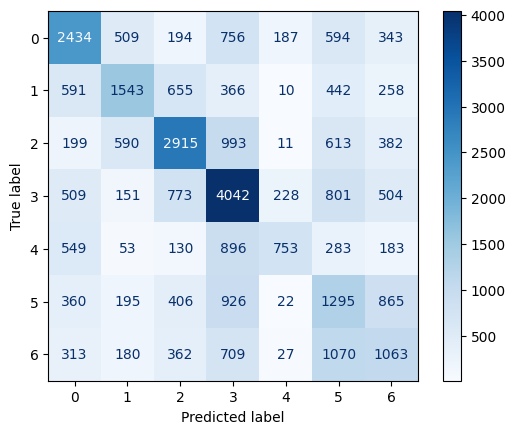

In [7]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [8]:
# Calculate class accuracies
class_accuracies = calculate_class_accuracies(cm)

# Display the class accuracies
for class_index, accuracy in class_accuracies.items():
    print(f"Class {class_index}: {accuracy:.2f}")

Class 0: 0.49
Class 1: 0.40
Class 2: 0.51
Class 3: 0.58
Class 4: 0.26
Class 5: 0.32
Class 6: 0.29


In [9]:
# Calculate custom accuracies
custom_accuracies = calculate_custom_accuracies(cm)

# Display the custom accuracies
for custom_index, accuracy in custom_accuracies.items():
    print(f"Class {custom_index-1}: {accuracy:.2f}")

Class 0: 0.62
Class 1: 0.72
Class 2: 0.79
Class 3: 0.72
Class 4: 0.77
Class 5: 0.32
Class 6: 0.29
